In [2]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

# 案例介绍

# 描述性分析

In [215]:
a = pd.read_csv('teaching.csv', encoding = 'gb18030', dtype = {'year' : str})
a.head()  #a.info()

,title,gender,student,year,semester,size,score
0,副教授,女,MBA,2002,秋季,114,3.175
1,副教授,女,MBA,2002,秋季,88,3.523
2,副教授,女,MBA,2003,秋季,83,4.458
3,副教授,女,MBA,2002,秋季,66,3.470
4,副教授,女,MBA,2003,秋季,46,4.630


In [216]:
#a['titles'] = a.title.apply(lambda x: 'AP' if x=='副教授' else( 'FP' if x=='正教授' else 'ASP'))
a['genders']=a.gender.apply(lambda x: 1 if x=='女' else 0)

Text(0, 0.5, 'score')

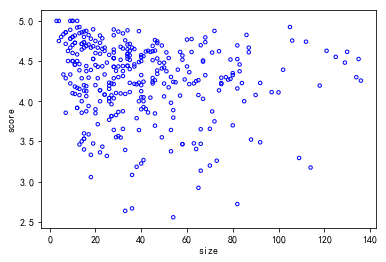

In [217]:
plt.scatter(a['size'],a['score'], s=12, facecolors='none', edgecolors='blue')
plt.xlabel('size')
plt.ylabel('score')

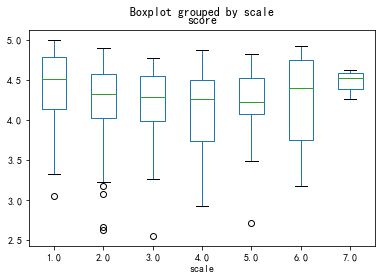

In [218]:
a['scale']=np.ceil(a['size']/20)
a.boxplot(column='score', by='scale',grid=False)

In [225]:
a['scale'].value_counts()

2.0    112
1.0     98
3.0     59
4.0     40
5.0     17
7.0      7
6.0      7
Name: scale, dtype: int64

In [203]:
del a['scale']
a['group'] = 1 * (a['size']<=20)

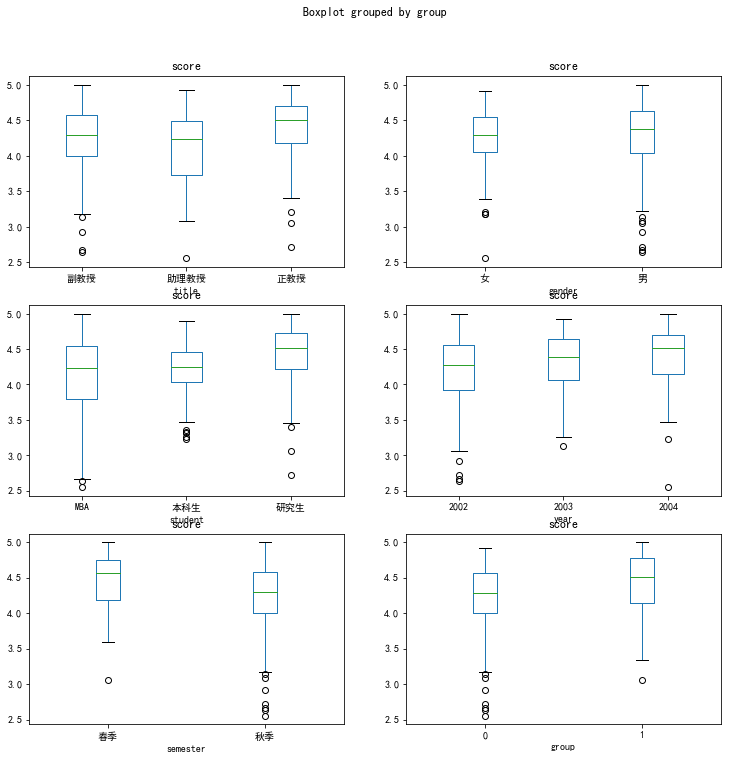

In [204]:
f, axes = plt.subplots(3, 2, figsize=(12, 12))   
a.boxplot(column='score', by='title',grid=False,ax=axes[0,0])
a.boxplot(column='score', by='gender',grid=False,ax=axes[0,1])
a.boxplot(column='score', by='student',grid=False,ax=axes[1,0])
a.boxplot(column='score', by='year',grid=False,ax=axes[1,1])
a.boxplot(column='score', by='semester',grid=False,ax=axes[2,0])
a.boxplot(column='score', by='group',grid=False,ax=axes[2,1])

# 单因素可加模型

$ 教学评估成绩 = (\alpha_0 + \alpha_1) + \beta \times 学生人数 + \epsilon, if group=1 $  
$ 教学评估成绩 = \alpha_0 + \beta \times 学生人数 + \epsilon, if group=0 $

In [205]:
lm1 = smf.ols('score ~ group + size', data=a).fit()
lm1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.033   
Dependent Variable: score            AIC:                452.6202
Date:               2019-04-03 17:02 BIC:                464.1071
No. Observations:   340              Log-Likelihood:     -223.31 
Df Model:           2                F-statistic:        6.742   
Df Residuals:       337              Prob (F-statistic): 0.00135 
R-squared:          0.038            Scale:              0.21971 
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
Intercept       4.2367    0.0667  63.5302  0.0000   4.1056  4.3679
group           0.1850    0.0714   2.5904  0.0100   0.0445  0.3256
size           -0.0005    0.0012  -0.4422  0.6586  -0.0028  0.0018
-----------------------------------------------------------------
Omnibus:              49.090       Durbin-Watson:          1.924 
Prob(Omnibus):        0.000        Jarque-Bera (JB):       66.140
Skew:                 -1.022       Prob(JB):               0.000 
Kurtosis:             3.703        Condition No.:          174   
=================================================================

"""

In [206]:
lm1.params

Intercept    4.236745
group        0.185043
size        -0.000519
dtype: float64

$ 教学评估成绩 = (4.237 + 0.185) - 0.001 \times 学生人数 + \epsilon, if group=1 $  
$ 教学评估成绩 = 4.237 - 0.001 \times 学生人数 + \epsilon, if group=0 $

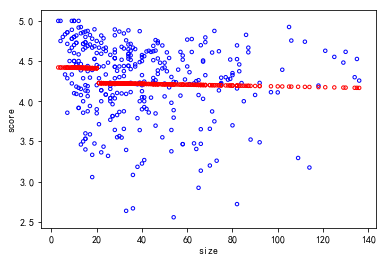

In [207]:
plt.scatter('size','score', data=a, s=12, facecolors='none', edgecolors='blue')
plt.xlabel('size')
plt.ylabel('score')
plt.scatter(a['size'], lm1.fittedvalues, s=12, facecolors='none', edgecolors='red')

从图中可以看到两条平行的直线，它们分别为不同班级规模的回归直线。显然这样的拟合效果并不理想。特别是对于小规模班级，教学评估成绩有一个很明显的下降趋势，但是我们拟合的回归直线却近乎于一条水平的直线。

# 单因素交互作用模型

$ 教学评估成绩 = (\alpha_0 + \alpha_1) + (\beta_0 + \beta_1) \times 学生人数 + \epsilon, if group=1 $  
$ 教学评估成绩 = \alpha_0 + \beta_0 \times 学生人数 + \epsilon, if group=0 $

In [208]:
lm2 = smf.ols('score ~ group * size', data=a).fit()
anova_lm(lm2, typ="III")

,sum_sq,df,F,PR(>F)
Intercept,870.978185,1.0,4083.196145,4.600881e-190
group,3.639469,1.0,17.062042,4.570737e-05
size,0.002311,1.0,0.010834,9.171621e-01
group:size,2.372375,1.0,11.121829,9.484975e-04
Residual,71.671470,336.0,NaN,NaN


从中可以看到，班级规模（group）的主效应高度显著。可见**班级规模**这一因素的重要性。 

**学生人数（size）的P值很大，这说明学生人数不重要吗？答案是否定的。**  
班级规模（group）和学生人数（size）的交互作用的P值很小，在0.001的水平下高度显著。  
只要该交互作用显著，或者学生人数（size）的主效应显著，我们就可以认为学生人数（size）这个因素是重要的。

In [209]:
lm2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.061   
Dependent Variable: score            AIC:                443.5482
Date:               2019-04-03 17:02 BIC:                458.8640
No. Observations:   340              Log-Likelihood:     -217.77 
Df Model:           3                F-statistic:        8.337   
Df Residuals:       336              Prob (F-statistic): 2.31e-05
R-squared:          0.069            Scale:              0.21331 
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept      4.2166    0.0660  63.8999  0.0000   4.0868   4.3464
group          0.6924    0.1676   4.1306  0.0000   0.3627   1.0221
size          -0.0001    0.0012  -0.1041  0.9172  -0.0024   0.0022
group:size    -0.0377    0.0113  -3.3349  0.0009  -0.0600  -0.0155
-----------------------------------------------------------------
Omnibus:              47.300       Durbin-Watson:          1.992 
Prob(Omnibus):        0.000        Jarque-Bera (JB):       63.019
Skew:                 -0.991       Prob(JB):               0.000 
Kurtosis:             3.719        Condition No.:          330   
=================================================================

"""

- **group=0, 学生人数超过20人的班级**  
  
  $ 教学评估成绩 = 4.2166 - 0.0001 \times 学生人数 + \epsilon $ 
  
  由于学生人数（size）的主效应估计量（-0.0001）太小，而且不显著（P值=0.917），因此对大规模班级（group=0）得出以下结论：
    1. 平均教学评估成绩约为4.2166；
    2. 学生人数的变化对教学评估成绩影响甚微。
   

- **group=1, 学生人数不超过20人的班级**  

  $$ \begin{eqnarray*}
  教学评估成绩 & = & (4.2166 + 0.6924) - (0.0001 + 0.0377) \times 学生人数 + \epsilon\\  
   & = & 4.9090 - 0.0378 \times 学生人数 + \epsilon \end{eqnarray*}$$
  
  
  由于学生人数（size）的主效应估计量（-0.0001）太小，而且不显著（P值=0.917），因此对小规模班级（group=1）得出以下结论：
    1. 如果一个教员教授一门有0个学生的课程（当然这是不可能的），那么他的教学评估成绩可以高达4.909；
    2. 随着学生人数的增加，其教学评估成绩以0.0378分/人的速度下降；
    3. 对于小规模班级（group=1），学生人数（size）的影响是很显著的。

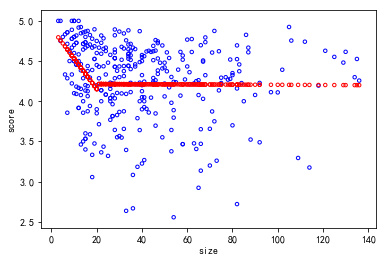

In [210]:
plt.scatter('size','score', data=a, s=12, facecolors='none', edgecolors='blue')
plt.xlabel('size')
plt.ylabel('score')
plt.scatter(a['size'], lm2.fittedvalues, s=12, facecolors='none', edgecolors='red')

从图中可以清楚看出，以学生人数20为届，我们拟合了两条不同的回归直线。  
其中，学生人数少于20的回归直线截距很高且下降迅速，  
   而学生人数大于20的回归直线基本保持水平。

# 多因素协方差分析

考虑如下统计模型：  
$ 教学评估成绩 = 教员职称 + 教员性别 + 学生类别 + 年份 + 学期 + 班级规模 \times 学生人数 + \epsilon $

In [211]:
lm31 = smf.ols('score ~ title+genders+student+year+semester+group * size', data=a).fit()
anova_lm(lm31, typ="III")

,sum_sq,df,F,PR(>F)
Intercept,252.177135,1.0,1351.760723,2.255591e-118
title,1.938447,2.0,5.195388,6.007221e-03
student,3.242909,2.0,8.691582,2.098551e-04
year,3.511289,2.0,9.410889,1.061371e-04
semester,0.011929,1.0,0.063945,8.005250e-01
genders,0.047006,1.0,0.251971,6.160271e-01
group,2.604529,1.0,13.961217,2.200647e-04
size,0.105781,1.0,0.567024,4.519841e-01
group:size,2.010103,1.0,10.774881,1.139731e-03
Residual,61.189898,328.0,NaN,NaN


In [180]:
lm31.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.179   
Dependent Variable: score            AIC:                405.7906
Date:               2019-04-03 16:53 BIC:                451.7380
No. Observations:   340              Log-Likelihood:     -190.90 
Df Model:           11               F-statistic:        7.707   
Df Residuals:       328              Prob (F-statistic): 7.23e-12
R-squared:          0.205            Scale:              0.18655 
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          3.9255   0.1068 36.7663 0.0000  3.7155  4.1355
title[T.助理教授]     -0.1006   0.0703 -1.4317 0.1532 -0.2388  0.0376
title[T.正教授]       0.1637   0.0696  2.3543 0.0191  0.0269  0.3006
student[T.本科生]     0.0945   0.0673  1.4027 0.1616 -0.0380  0.2269
student[T.研究生]     0.2429   0.0583  4.1692 0.0000  0.1283  0.3575
year[T.2003]       0.1446   0.0594  2.4368 0.0153  0.0279  0.2614
year[T.2004]       0.2404   0.0569  4.2218 0.0000  0.1284  0.3524
semester[T.秋季]    -0.0214   0.0845 -0.2529 0.8005 -0.1877  0.1449
sex                0.0334   0.0665  0.5020 0.6160 -0.0974  0.1641
group              0.6018   0.1611  3.7365 0.0002  0.2850  0.9187
size               0.0009   0.0012  0.7530 0.4520 -0.0015  0.0033
group:size        -0.0351   0.0107 -3.2825 0.0011 -0.0562 -0.0141
-----------------------------------------------------------------
Omnibus:              41.314       Durbin-Watson:          2.142 
Prob(Omnibus):        0.000        Jarque-Bera (JB):       53.427
Skew:                 -0.883       Prob(JB):               0.000 
Kurtosis:             3.807        Condition No.:          339   
=================================================================

"""

In [181]:
lm32 = smf.ols('score ~ title+student+year+group * size', data=a).fit()  # 去掉教员性别（gender）和学期（semester）
anova_lm(lm32, typ="III")

,sum_sq,df,F,PR(>F)
Intercept,416.906120,1.0,2246.554354,2.542363e-149
title,3.568658,2.0,9.615096,8.736872e-05
student,3.242879,2.0,8.737343,2.006674e-04
year,3.566751,2.0,9.609958,8.779395e-05
group,2.567771,1.0,13.836779,2.342672e-04
size,0.086642,1.0,0.466885,4.949033e-01
group:size,1.995607,1.0,10.753594,1.151792e-03
Residual,61.240014,330.0,NaN,NaN


In [182]:
lm32.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.183   
Dependent Variable: score            AIC:                402.0690
Date:               2019-04-03 16:53 BIC:                440.3584
No. Observations:   340              Log-Likelihood:     -191.03 
Df Model:           9                F-statistic:        9.440   
Df Residuals:       330              Prob (F-statistic): 8.42e-13
R-squared:          0.205            Scale:              0.18558 
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          3.9161   0.0826 47.3978 0.0000  3.7536  4.0786
title[T.助理教授]     -0.0962   0.0695 -1.3850 0.1670 -0.2328  0.0404
title[T.正教授]       0.1748   0.0525  3.3313 0.0010  0.0716  0.2781
student[T.本科生]     0.0954   0.0671  1.4204 0.1564 -0.0367  0.2274
student[T.研究生]     0.2416   0.0578  4.1802 0.0000  0.1279  0.3552
year[T.2003]       0.1470   0.0590  2.4927 0.0132  0.0310  0.2630
year[T.2004]       0.2415   0.0567  4.2558 0.0000  0.1299  0.3531
group              0.5962   0.1603  3.7198 0.0002  0.2809  0.9115
size               0.0008   0.0011  0.6833 0.4949 -0.0014  0.0029
group:size        -0.0349   0.0107 -3.2793 0.0012 -0.0559 -0.0140
-----------------------------------------------------------------
Omnibus:              41.313       Durbin-Watson:          2.141 
Prob(Omnibus):        0.000        Jarque-Bera (JB):       53.315
Skew:                 -0.886       Prob(JB):               0.000 
Kurtosis:             3.788        Condition No.:          338   
=================================================================

"""

报表中每个因素下消失的水平：
- 教员职称：副教授
- 学生类别：MBA
- 年份：2002年
- 班级规模：人数大于20人的班级  
这说明，我们的标准课程类型为**2002年副教授讲授的MBA课程，且学生人数超过20人**。（此标准课程对应于一条标准的关于学生人数的回归直线）。  
$$ \begin{eqnarray*}
  教学评估成绩 = 3.916 + 0.001 \times 学生人数 + \epsilon\\  
  \end{eqnarray*}$$

若我们感兴趣的课程是**2002年副教授讲授的MBA课程，且学生人数不超过20人**，其回归直线为：
$$ \begin{eqnarray*}
  教学评估成绩 & = & 3.916 + (0.001 - 0.035) \times 学生人数 + \epsilon\\  
   & = & 3.916 - 0.034 \times 学生人数 + \epsilon \end{eqnarray*}$$

若我们感兴趣的课程是**2003年某助理教授讲授的本科生课程，且学生人数不超过20人**，其回归直线为：  
  $$ \begin{eqnarray*}
  教学评估成绩 & = & (3.916 -0.096 + 0.095 + 0.147) + (0.001 - 0.035) \times 学生人数 + \epsilon\\  
   & = & 4.062 - 0.034 \times 学生人数 + \epsilon \end{eqnarray*}$$

结论：  
1. 教员职称显著影响教学评估成绩。随着教员职称的提高（从助理教授到副教授再到正教授），平均教学评估成绩（以中位数计）依次增高；  
2. 不同的学生类别对教学评估成绩影响很大。普通研究生给出的平均教学评估成绩明显高于本科生和MBA，而本科生和MBA之间差异大；  
3. 随着时间的推移，北京大学光华管理学院的教学评估成绩稳步提高；  
4. 小于20人的班级的教学评估成绩明显高于大于20人的班级；  
5. 学生人数对大规模班级影响甚微，但对小规模班级影响显著。

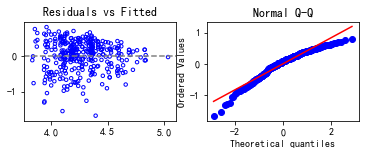

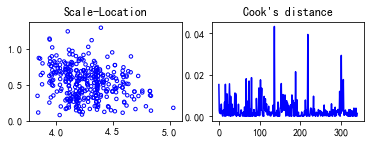

In [184]:
# 1
plt.subplot(221)
plt.scatter(lm32.fittedvalues, lm32.resid, s=12, facecolors='none', edgecolors='blue')
plt.axhline(y=0,linestyle='--',color='grey')
plt.title('Residuals vs Fitted')

# 2
plt.subplot(222)
stats.probplot(lm32.resid,dist='norm',plot=plt)
plt.title('Normal Q-Q')
plt.show()

# 3
plt.subplot(223)
plt.scatter(lm32.fittedvalues, abs(lm32.resid) ** 0.5, s=12, facecolors='none', edgecolors='blue')
#plt.ylabel("")
plt.title("Scale-Location")

# 4
plt.subplot(224)
lm32_influence = lm32.get_influence()
plt.plot(lm32_influence.cooks_distance[0],color='blue')
plt.title("Cook's distance");

# 模型选择与预测

In [185]:
anova_lm(lm31, typ="III")

,sum_sq,df,F,PR(>F)
Intercept,252.177135,1.0,1351.760723,2.255591e-118
title,1.938447,2.0,5.195388,6.007221e-03
student,3.242909,2.0,8.691582,2.098551e-04
year,3.511289,2.0,9.410889,1.061371e-04
semester,0.011929,1.0,0.063945,8.005250e-01
sex,0.047006,1.0,0.251971,6.160271e-01
group,2.604529,1.0,13.961217,2.200647e-04
size,0.105781,1.0,0.567024,4.519841e-01
group:size,2.010103,1.0,10.774881,1.139731e-03
Residual,61.189898,328.0,NaN,NaN


In [6]:
# 计算AIC
lm31_AIC = 340*(math.log(61.190/340) + 1 + math.log(2*math.pi)) + 2 * (12 + 1)
round(lm31_AIC,2)

407.79

In [8]:
# 计算IC
lm31_BIC = 340*(math.log(61.190/340) + 1 + math.log(2*math.pi)) + math.log(340) * (12 + 1)
round(lm31_BIC,2)

457.57

In [227]:
lm31.summary2().tables[0]  # python中自动计算结果与手动结果稍微有差异

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.179
1,Dependent Variable:,score,AIC:,405.7906
2,Date:,2019-04-03 18:50,BIC:,451.7380
3,No. Observations:,340,Log-Likelihood:,-190.90
4,Df Model:,11,F-statistic:,7.707
5,Df Residuals:,328,Prob (F-statistic):,7.23e-12
6,R-squared:,0.205,Scale:,0.18655


In [187]:
anova_lm(lm32, typ="III")

,sum_sq,df,F,PR(>F)
Intercept,416.906120,1.0,2246.554354,2.542363e-149
title,3.568658,2.0,9.615096,8.736872e-05
student,3.242879,2.0,8.737343,2.006674e-04
year,3.566751,2.0,9.609958,8.779395e-05
group,2.567771,1.0,13.836779,2.342672e-04
size,0.086642,1.0,0.466885,4.949033e-01
group:size,1.995607,1.0,10.753594,1.151792e-03
Residual,61.240014,330.0,NaN,NaN


In [10]:
# 计算AIC
lm32_AIC = 340*(math.log(61.240/340) + 1 + math.log(2*math.pi)) + 2 * (10 + 1)
round(lm32_AIC,3)

404.069

In [14]:
# 计算BIC
lm32_BIC = 340*(math.log(61.240/340) + 1 + math.log(2*math.pi)) + math.log(340) * (10 + 1)
round(lm32_BIC,3)

446.187

In [188]:
lm32.summary2().tables[0]

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.183
1,Dependent Variable:,score,AIC:,402.0690
2,Date:,2019-04-03 16:53,BIC:,440.3584
3,No. Observations:,340,Log-Likelihood:,-191.03
4,Df Model:,9,F-statistic:,9.440
5,Df Residuals:,330,Prob (F-statistic):,8.42e-13
6,R-squared:,0.205,Scale:,0.18558


In [189]:
s32=lm32.summary2()

In [190]:
s32.tables[0]

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.183
1,Dependent Variable:,score,AIC:,402.0690
2,Date:,2019-04-03 16:53,BIC:,440.3584
3,No. Observations:,340,Log-Likelihood:,-191.03
4,Df Model:,9,F-statistic:,9.440
5,Df Residuals:,330,Prob (F-statistic):,8.42e-13
6,R-squared:,0.205,Scale:,0.18558


In [191]:
lm32 = smf.ols('score ~ title+student+year+group * size', data=a).fit()  # 去掉教员性别（gender）和学期（semester）
anova_lm(lm32, typ="III")

,sum_sq,df,F,PR(>F)
Intercept,416.906120,1.0,2246.554354,2.542363e-149
title,3.568658,2.0,9.615096,8.736872e-05
student,3.242879,2.0,8.737343,2.006674e-04
year,3.566751,2.0,9.609958,8.779395e-05
group,2.567771,1.0,13.836779,2.342672e-04
size,0.086642,1.0,0.466885,4.949033e-01
group:size,1.995607,1.0,10.753594,1.151792e-03
Residual,61.240014,330.0,NaN,NaN


In [192]:
a.head()

,title,gender,student,year,semester,size,score,sex,group
0,副教授,女,MBA,2002,秋季,114,3.175,1,0
1,副教授,女,MBA,2002,秋季,88,3.523,1,0
2,副教授,女,MBA,2003,秋季,83,4.458,1,0
3,副教授,女,MBA,2002,秋季,66,3.470,1,0
4,副教授,女,MBA,2003,秋季,46,4.630,1,0


In [193]:
lm31 = smf.ols('score ~ title+genders+student+year+semester+group * size', data=a).fit()

In [194]:
a0 = pd.read_csv('new.csv', encoding = 'gb18030', dtype = {'year' : str})
a0['group'] = 1*(a0['size']<=20)
a0

,title,gender,student,year,semester,size,group
0,副教授,女,MBA,2002,秋季,114,0
1,副教授,男,研究生,2004,秋季,15,1
2,助理教授,女,本科生,2004,秋季,38,0
3,正教授,男,研究生,2002,春季,40,0
4,正教授,男,研究生,2003,春季,21,0


In [195]:
a0['score_hat'] = lm32.predict(a0)
a0

,title,gender,student,year,semester,size,group,score_hat
0,副教授,女,MBA,2002,秋季,114,0,4.002468
1,副教授,男,研究生,2004,秋季,15,1,4.482488
2,助理教授,女,本科生,2004,秋季,38,0,4.185510
3,正教授,男,研究生,2002,春季,40,0,4.362787
4,正教授,男,研究生,2003,春季,21,0,4.495394


# 更科学的绩效评估

In [196]:
lm32.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.183   
Dependent Variable: score            AIC:                402.0690
Date:               2019-04-03 16:53 BIC:                440.3584
No. Observations:   340              Log-Likelihood:     -191.03 
Df Model:           9                F-statistic:        9.440   
Df Residuals:       330              Prob (F-statistic): 8.42e-13
R-squared:          0.205            Scale:              0.18558 
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          3.9161   0.0826 47.3978 0.0000  3.7536  4.0786
title[T.助理教授]     -0.0962   0.0695 -1.3850 0.1670 -0.2328  0.0404
title[T.正教授]       0.1748   0.0525  3.3313 0.0010  0.0716  0.2781
student[T.本科生]     0.0954   0.0671  1.4204 0.1564 -0.0367  0.2274
student[T.研究生]     0.2416   0.0578  4.1802 0.0000  0.1279  0.3552
year[T.2003]       0.1470   0.0590  2.4927 0.0132  0.0310  0.2630
year[T.2004]       0.2415   0.0567  4.2558 0.0000  0.1299  0.3531
group              0.5962   0.1603  3.7198 0.0002  0.2809  0.9115
size               0.0008   0.0011  0.6833 0.4949 -0.0014  0.0029
group:size        -0.0349   0.0107 -3.2793 0.0012 -0.0559 -0.0140
-----------------------------------------------------------------
Omnibus:              41.313       Durbin-Watson:          2.141 
Prob(Omnibus):        0.000        Jarque-Bera (JB):       53.315
Skew:                 -0.886       Prob(JB):               0.000 
Kurtosis:             3.788        Condition No.:          338   
=================================================================

"""

In [197]:
a['adj_score'] = lm32.resid
a.loc[:9,['title','gender','student','year','semester','size','group','score','adj_score']]

,title,gender,student,year,semester,size,group,score,adj_score
0,副教授,女,MBA,2002,秋季,114,0,3.175,-0.827468
1,副教授,女,MBA,2002,秋季,88,0,3.523,-0.459766
2,副教授,女,MBA,2003,秋季,83,0,4.458,0.332018
3,副教授,女,MBA,2002,秋季,66,0,3.470,-0.496095
4,副教授,女,MBA,2003,秋季,46,0,4.630,0.532056
5,副教授,女,MBA,2004,秋季,45,0,4.511,0.319334
6,副教授,女,MBA,2002,秋季,38,0,3.184,-0.760877
7,副教授,女,MBA,2002,秋季,31,0,3.548,-0.391573
8,副教授,女,MBA,2003,秋季,30,0,4.433,0.347180
9,副教授,女,MBA,2004,秋季,30,0,4.300,0.119701
